<a href="https://colab.research.google.com/github/yamunadevi-13/primetrade/blob/main/Primetrade.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Install required libraries
!pip install pandas numpy matplotlib seaborn plotly scipy scikit-learn

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

# Set up plotting style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

# Load datasets
# Note: Replace with actual file paths after downloading from Google Drive
trader_data = pd.read_csv('/content/trader_data.csv')
sentiment_data = pd.read_csv('/content/fear_greed_index.csv')

# Initial data exploration
print("=== TRADER DATA OVERVIEW ===")
print(f"Shape: {trader_data.shape}")
print(f"Columns: {trader_data.columns.tolist()}")
print(trader_data.head())
print("\n" + "="*50 + "\n")

print("=== SENTIMENT DATA OVERVIEW ===")
print(f"Shape: {sentiment_data.shape}")
print(f"Columns: {sentiment_data.columns.tolist()}")
print(sentiment_data.head())

=== TRADER DATA OVERVIEW ===
Shape: (211224, 16)
Columns: ['Account', 'Coin', 'Execution Price', 'Size Tokens', 'Size USD', 'Side', 'Timestamp IST', 'Start Position', 'Direction', 'Closed PnL', 'Transaction Hash', 'Order ID', 'Crossed', 'Fee', 'Trade ID', 'Timestamp']
                                      Account  Coin  Execution Price  \
0  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9769   
1  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9800   
2  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9855   
3  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9874   
4  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9894   

   Size Tokens  Size USD Side     Timestamp IST  Start Position Direction  \
0       986.87   7872.16  BUY  02-12-2024 22:50        0.000000       Buy   
1        16.00    127.68  BUY  02-12-2024 22:50      986.524596       Buy   
2       144.09   1150.63  BUY  02-12-2024 22:50     1002.518996    

In [ ]:
# Clean and preprocess trader data
def clean_trader_data(df):
    print(f"Original dataset shape: {df.shape}")
    print(f"Missing values:\n{df.isnull().sum()}")

    timestamp_cols = [col for col in df.columns if 'timestamp' in col.lower()]
    print(f"Available timestamp columns: {timestamp_cols}")

    # Initialize variable to hold the best timestamp column name
    best_col = None
    min_missing = None

    # Find the timestamp column with least missing values
    for col in timestamp_cols:
        missing = df[col].isnull().sum()
        if min_missing is None or missing < min_missing:
            min_missing = missing
            best_col = col

    if best_col is not None:
        print(f"Using '{best_col}' as timestamp column with {min_missing} missing values")
        df['time'] = pd.to_datetime(df[best_col], errors='coerce')
    else:
        raise KeyError("No timestamp column found.")

    # Remove rows where time is missing
    print(f"Rows with missing time before cleaning: {df['time'].isnull().sum()}")
    df = df.dropna(subset=['time'])
    print(f"Dataset shape after removing rows with missing time: {df.shape}")

    # Create date column
    df['date'] = df['time'].dt.date

    # Handle missing values in critical columns
    critical_cols = []
    if 'Execution Price' in df.columns:
        critical_cols.append('Execution Price')
    if 'Size USD' in df.columns:
        critical_cols.append('Size USD')
    elif 'Size Tokens' in df.columns:
        critical_cols.append('Size Tokens')
    if 'Side' in df.columns:
        critical_cols.append('Side')

    print(f"Critical columns for analysis: {critical_cols}")

    # Remove rows with missing values in critical columns
    df = df.dropna(subset=critical_cols)
    print(f"Dataset shape after removing rows with missing critical values: {df.shape}")

    # Standardize column names (remove spaces, make lowercase)
    df.columns = df.columns.str.replace(' ', '_').str.lower()

    # Convert numeric columns
    numeric_mapping = {
        'execution_price': 'execution_price',
        'size_usd': 'size_usd',
        'size_tokens': 'size_tokens',
        'closed_pnl': 'closed_pnl',
        'fee': 'fee'
    }

    for col in numeric_mapping.values():
        if col in df.columns:
            df[col] = pd.to_numeric(df[col], errors='coerce')

    # Create trade_value column using available size column
    if 'size_usd' in df.columns:
        df['trade_value'] = df['size_usd']
    elif 'size_tokens' in df.columns and 'execution_price' in df.columns:
        df['trade_value'] = df['execution_price'] * df['size_tokens']
    else:
        print("Warning: Could not create trade_value column")

    # Create time-based features
    df['hour'] = df['time'].dt.hour
    df['day_of_week'] = df['time'].dt.dayofweek
    df['month'] = df['time'].dt.month
    df['year'] = df['time'].dt.year

    # Clean side column (buy/sell)
    if 'side' in df.columns:
        df['side'] = df['side'].str.lower().str.strip()

    # Handle PnL column
    if 'closed_pnl' in df.columns:
        # Fill missing PnL with 0 (assuming positions that weren't closed)
        df['closed_pnl'] = df['closed_pnl'].fillna(0)

    print(f"Final cleaned dataset shape: {df.shape}")
    print(f"Date range: {df['date'].min()} to {df['date'].max()}")

    return df

# Clean and preprocess sentiment data
def clean_sentiment_data(df):
    print(f"Sentiment data shape: {df.shape}")
    print(f"Sentiment data columns: {df.columns.tolist()}")
    print(f"Missing values in sentiment data:\n{df.isnull().sum()}")

    # Convert 'date' column to datetime
    df['date'] = pd.to_datetime(df['date'], errors='coerce')
    df = df.dropna(subset=['date'])

    # Clean classification column
    if 'classification' in df.columns:
        df['classification'] = df['classification'].astype(str).str.strip().str.title()

    print(f"Unique sentiment classifications: {df['classification'].unique()}")

    return df


# Apply cleaning functions
print("=== CLEANING TRADER DATA ===")
trader_data_clean = clean_trader_data(trader_data)

print("\n=== CLEANING SENTIMENT DATA ===")
sentiment_data_clean = clean_sentiment_data(sentiment_data)

print("\n=== FINAL SUMMARY ===")
print(f"Trader data shape after cleaning: {trader_data_clean.shape}")
print(f"Sentiment data shape after cleaning: {sentiment_data_clean.shape}")

# Display sample of cleaned data
print("\n=== SAMPLE OF CLEANED TRADER DATA ===")
print(trader_data_clean.head())
print("\n=== SAMPLE OF CLEANED SENTIMENT DATA ===")
print(sentiment_data_clean.head())

=== CLEANING TRADER DATA ===
Original dataset shape: (211224, 16)
Missing values:
Account             0
Coin                0
Execution Price     0
Size Tokens         0
Size USD            0
Side                0
Timestamp IST       0
Start Position      0
Direction           0
Closed PnL          0
Transaction Hash    0
Order ID            0
Crossed             0
Fee                 0
Trade ID            0
Timestamp           0
dtype: int64
Available timestamp columns: ['Timestamp IST', 'Timestamp']
Using 'Timestamp IST' as timestamp column with 0 missing values
Rows with missing time before cleaning: 131999
Dataset shape after removing rows with missing time: (79225, 17)
Critical columns for analysis: ['Execution Price', 'Size USD', 'Side']
Dataset shape after removing rows with missing critical values: (79225, 18)
Final cleaned dataset shape: (79225, 23)
Date range: 2023-01-05 to 2025-12-04

=== CLEANING SENTIMENT DATA ===
Sentiment data shape: (2644, 4)
Sentiment data columns: ['t

=== TRADER BEHAVIOR ANALYSIS ===
Available columns for analysis: ['date', 'trade_value', 'side', 'hour']


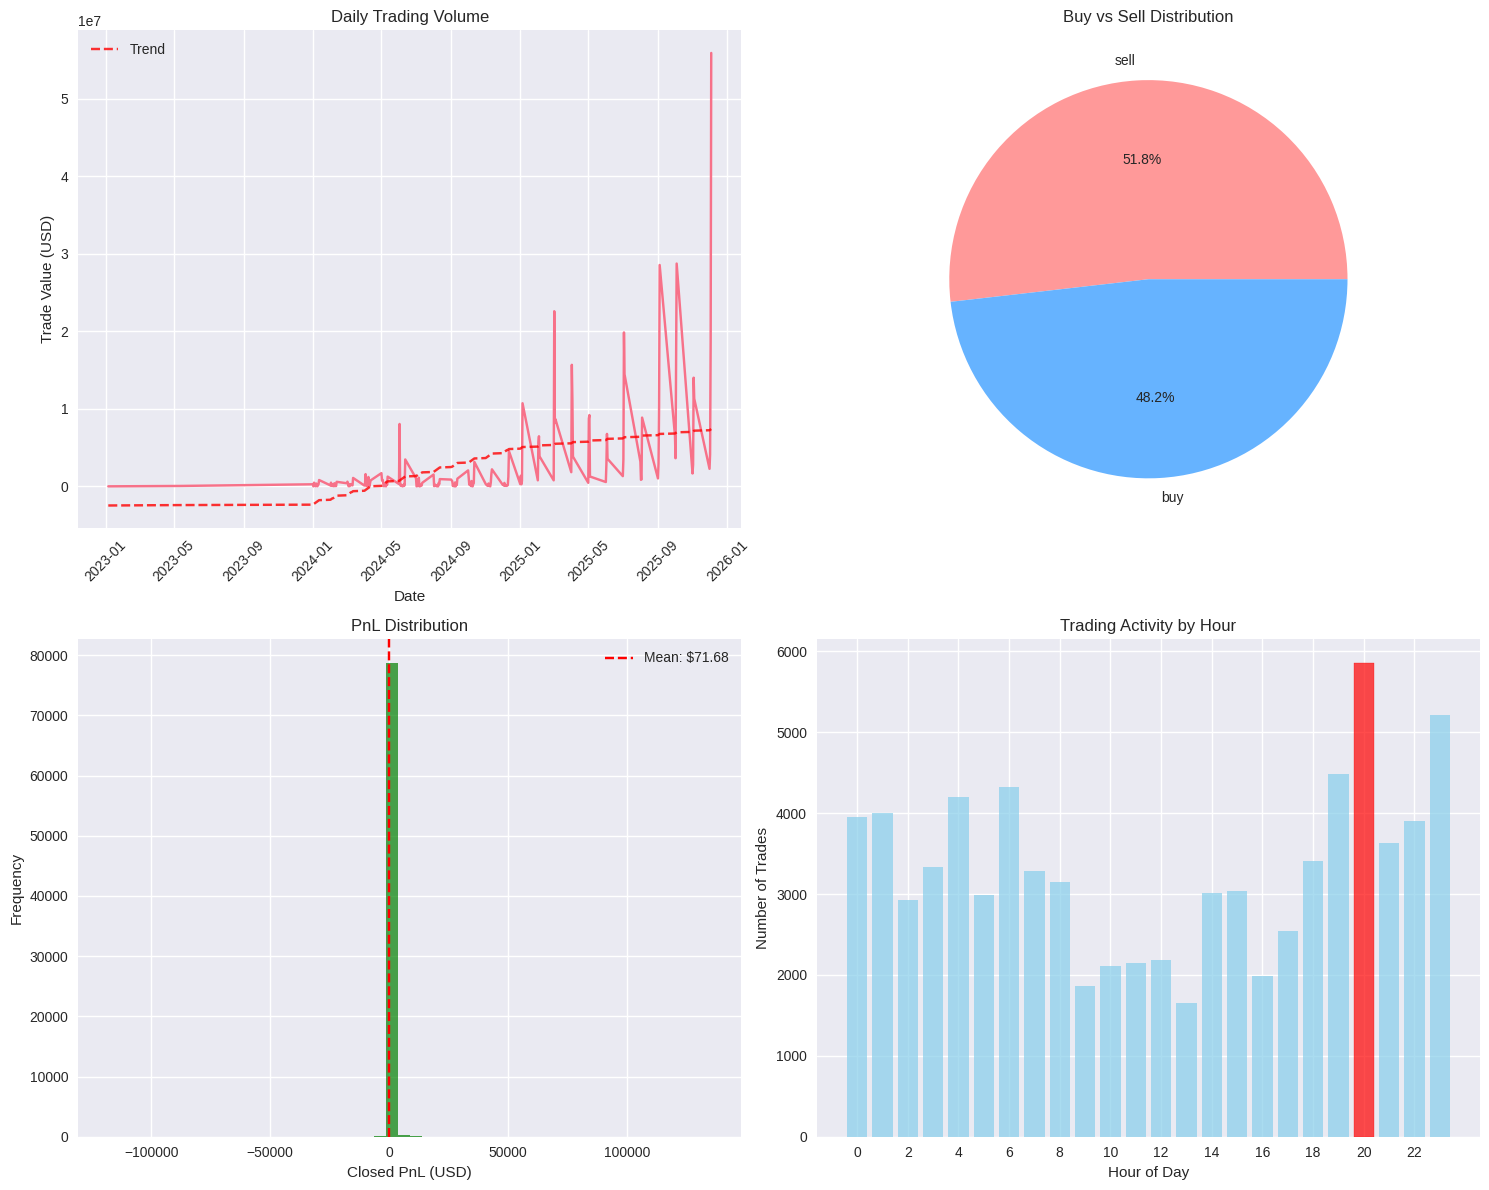


=== SUMMARY STATISTICS ===
Total trading volume: $462,854,466.85
Average trade size: $5,842.28
Median trade size: $662.02
Buy ratio: 48.2%
Sell ratio: 51.8%
Profitable trades: 33462/79225 (42.2%)
Average PnL: $71.68

=== MARKET SENTIMENT ANALYSIS ===


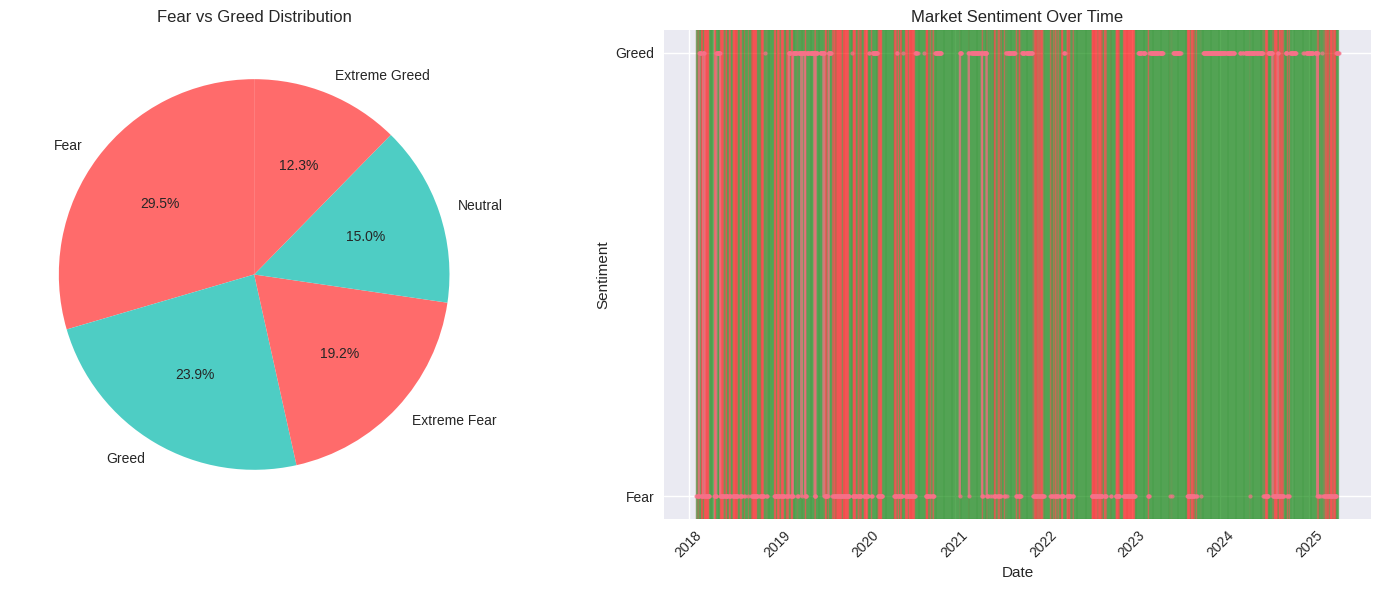

Total sentiment observations: 2644
Date range: 2018-02-01 00:00:00 to 2025-05-02 00:00:00
Fear periods: 781 (29.5%)
Greed periods: 633 (23.9%)


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os

# EDA for Trader Data
def analyze_trader_behavior(df):
    print("=== TRADER BEHAVIOR ANALYSIS ===")

    # Check if we have the necessary columns
    required_cols = ['date', 'trade_value', 'side', 'hour']
    available_cols = [col for col in required_cols if col in df.columns]
    print(f"Available columns for analysis: {available_cols}")

    # Create figure with subplots
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))

    # 1. Trading volume over time
    if 'trade_value' in df.columns:
        daily_volume = df.groupby('date')['trade_value'].sum().reset_index()
        daily_volume['date'] = pd.to_datetime(daily_volume['date'])

        axes[0,0].plot(daily_volume['date'], daily_volume['trade_value'])
        axes[0,0].set_title('Daily Trading Volume')
        axes[0,0].set_xlabel('Date')
        axes[0,0].set_ylabel('Trade Value (USD)')
        axes[0,0].tick_params(axis='x', rotation=45)

        # Add trend line
        z = np.polyfit(range(len(daily_volume)), daily_volume['trade_value'], 1)
        p = np.poly1d(z)
        axes[0,0].plot(daily_volume['date'], p(range(len(daily_volume))),
                      "r--", alpha=0.8, label='Trend')
        axes[0,0].legend()
    else:
        axes[0,0].text(0.5, 0.5, 'Trade value data not available',
                      ha='center', va='center', transform=axes[0,0].transAxes)

    # 2. Buy vs Sell distribution
    if 'side' in df.columns:
        side_counts = df['side'].value_counts()
        colors = ['#ff9999', '#66b3ff']
        axes[0,1].pie(side_counts.values, labels=side_counts.index,
                     autopct='%1.1f%%', colors=colors)
        axes[0,1].set_title('Buy vs Sell Distribution')
    else:
        axes[0,1].text(0.5, 0.5, 'Side data not available',
                      ha='center', va='center', transform=axes[0,1].transAxes)

    # 3. PnL distribution
    if 'closed_pnl' in df.columns:
        pnl_data = df['closed_pnl'].dropna()
        if len(pnl_data) > 0:
            axes[1,0].hist(pnl_data, bins=50, alpha=0.7, color='green')
            axes[1,0].axvline(pnl_data.mean(), color='red', linestyle='--',
                            label=f'Mean: ${pnl_data.mean():.2f}')
            axes[1,0].set_title('PnL Distribution')
            axes[1,0].set_xlabel('Closed PnL (USD)')
            axes[1,0].set_ylabel('Frequency')
            axes[1,0].legend()
        else:
            axes[1,0].text(0.5, 0.5, 'No PnL data available',
                          ha='center', va='center', transform=axes[1,0].transAxes)
    else:
        axes[1,0].text(0.5, 0.5, 'PnL data not available',
                      ha='center', va='center', transform=axes[1,0].transAxes)

    # 4. Trading activity by hour
    if 'hour' in df.columns:
        hourly_activity = df.groupby('hour').size()
        bars = axes[1,1].bar(hourly_activity.index, hourly_activity.values,
                            color='skyblue', alpha=0.7)
        axes[1,1].set_title('Trading Activity by Hour')
        axes[1,1].set_xlabel('Hour of Day')
        axes[1,1].set_ylabel('Number of Trades')
        axes[1,1].set_xticks(range(0, 24, 2))

        # Highlight peak hours
        max_hour = hourly_activity.idxmax()
        bars[max_hour].set_color('red')
    else:
        axes[1,1].text(0.5, 0.5, 'Hour data not available',
                      ha='center', va='center', transform=axes[1,1].transAxes)

    plt.tight_layout()
    os.makedirs('/content/outputs', exist_ok=True)
    plt.savefig('/content/outputs/trader_behavior_analysis.png', dpi=300, bbox_inches='tight')
    plt.show()

    # Print summary statistics
    print("\n=== SUMMARY STATISTICS ===")
    if 'trade_value' in df.columns:
        print(f"Total trading volume: ${df['trade_value'].sum():,.2f}")
        print(f"Average trade size: ${df['trade_value'].mean():,.2f}")
        print(f"Median trade size: ${df['trade_value'].median():,.2f}")

    if 'side' in df.columns:
        side_dist = df['side'].value_counts(normalize=True)
        print(f"Buy ratio: {side_dist.get('buy', 0):.1%}")
        print(f"Sell ratio: {side_dist.get('sell', 0):.1%}")

    if 'closed_pnl' in df.columns:
        profitable_trades = (df['closed_pnl'] > 0).sum()
        total_trades = len(df[df['closed_pnl'].notna()])
        if total_trades > 0:
            print(f"Profitable trades: {profitable_trades}/{total_trades} ({profitable_trades/total_trades:.1%})")
            print(f"Average PnL: ${df['closed_pnl'].mean():.2f}")

# EDA for Sentiment Data
def analyze_market_sentiment(df):
    print("\n=== MARKET SENTIMENT ANALYSIS ===")

    fig, axes = plt.subplots(1, 2, figsize=(15, 6))

    # 1. Fear vs Greed distribution
    sentiment_counts = df['classification'].value_counts()
    colors = ['#ff6b6b', '#4ecdc4']  # Red for fear, teal for greed
    wedges, texts, autotexts = axes[0].pie(
        sentiment_counts.values,
        labels=sentiment_counts.index,
        autopct='%1.1f%%',
        colors=colors,
        startangle=90)
    axes[0].set_title('Fear vs Greed Distribution')

    # 2. Sentiment over time
    df['date'] = pd.to_datetime(df['date'])

    # Sort by date
    df_sorted = df.sort_values(by='date')

    # Create time series indexed by date for classification
    sentiment_timeline = df_sorted.set_index('date')['classification']

    # Map sentiment labels to numeric values for plotting
    sentiment_numeric = sentiment_timeline.map({'Fear': 0, 'Greed': 1})

    axes[1].plot(sentiment_timeline.index, sentiment_numeric, marker='o', markersize=3, alpha=0.7)
    axes[1].set_title('Market Sentiment Over Time')
    axes[1].set_xlabel('Date')
    axes[1].set_ylabel('Sentiment')
    axes[1].set_yticks([0, 1])
    axes[1].set_yticklabels(['Fear', 'Greed'])
    axes[1].tick_params(axis='x', rotation=45)

    # Add sentiment period shading
    for i in range(len(sentiment_timeline) - 1):
        start_date = sentiment_timeline.index[i]
        end_date = sentiment_timeline.index[i + 1]
        if sentiment_timeline.iloc[i] == 'Fear':
            axes[1].axvspan(start_date, end_date, alpha=0.3, color='red')
        else:
            axes[1].axvspan(start_date, end_date, alpha=0.3, color='green')

    plt.tight_layout()
    os.makedirs('/content/outputs', exist_ok=True)
    plt.savefig('/content/outputs/market_sentiment_analysis.png', dpi=300, bbox_inches='tight')
    plt.show()

    # Print sentiment statistics
    print(f"Total sentiment observations: {len(df)}")
    print(f"Date range: {df['date'].min()} to {df['date'].max()}")
    print(f"Fear periods: {sentiment_counts.get('Fear', 0)} ({sentiment_counts.get('Fear', 0)/len(df)*100:.1f}%)")
    print(f"Greed periods: {sentiment_counts.get('Greed', 0)} ({sentiment_counts.get('Greed', 0)/len(df)*100:.1f}%)")

# Create outputs directory
os.makedirs('/content/outputs', exist_ok=True)

# Run EDA
analyze_trader_behavior(trader_data_clean)
analyze_market_sentiment(sentiment_data_clean)


In [ ]:
# Merge datasets on date
def merge_datasets(trader_df, sentiment_df):
    print("=== MERGING DATASETS ===")

    # First, let's check the date ranges
    print(f"Trader data date range: {trader_df['date'].min()} to {trader_df['date'].max()}")
    print(f"Sentiment data date range: {sentiment_df['date'].min()} to {sentiment_df['date'].max()}")

    # Check available columns for aggregation
    available_cols = trader_df.columns.tolist()
    print(f"Available columns for aggregation: {available_cols}")

    # Prepare aggregation dictionary based on available columns
    agg_dict = {}

    # Volume/Value metrics
    if 'trade_value' in trader_df.columns:
        agg_dict['trade_value'] = ['sum', 'mean', 'count']

    # PnL metrics
    if 'closed_pnl' in trader_df.columns:
        agg_dict['closed_pnl'] = ['sum', 'mean', 'std']

    # Side analysis (buy/sell ratio)
    if 'side' in trader_df.columns:
        agg_dict['side'] = lambda x: (x == 'buy').mean()  # Buy ratio

    # Fee analysis
    if 'fee' in trader_df.columns:
        agg_dict['fee'] = ['sum', 'mean']

    # Size analysis
    if 'size_usd' in trader_df.columns:
        agg_dict['size_usd'] = ['sum', 'mean', 'std']
    elif 'size_tokens' in trader_df.columns:
        agg_dict['size_tokens'] = ['sum', 'mean', 'std']

    print(f"Aggregation dictionary: {agg_dict}")

    # Aggregate trader data by date
    if agg_dict:
        daily_trader_metrics = trader_df.groupby('date').agg(agg_dict).reset_index()

        # Flatten column names
        new_columns = ['date']
        for col in daily_trader_metrics.columns[1:]:
            if isinstance(col, tuple):
                if col[1] == '<lambda>':
                    new_columns.append(f"{col[0]}_buy_ratio")
                else:
                    new_columns.append(f"{col[0]}_{col[1]}")
            else:
                new_columns.append(col)

        daily_trader_metrics.columns = new_columns

        print(f"Aggregated trader metrics columns: {daily_trader_metrics.columns.tolist()}")
        print(f"Daily trader metrics shape: {daily_trader_metrics.shape}")
    else:
        print("No suitable columns found for aggregation")
        return None

    # Convert date column to datetime for merging
    daily_trader_metrics['date'] = pd.to_datetime(daily_trader_metrics['date'])
    sentiment_df['date'] = pd.to_datetime(sentiment_df['date'])  # ensure datetime type
    # Merge with sentiment data using lowercase 'date' for both
    merged_df = pd.merge(daily_trader_metrics, sentiment_df,
                     left_on='date', right_on='date', how='inner')


    print(f"Merged dataset shape: {merged_df.shape}")
    print(f"Merged date range: {merged_df['date'].min()} to {merged_df['date'].max()}")

    if len(merged_df) == 0:
        print("WARNING: No overlapping dates found between datasets!")
        print("Trying outer join to see all available dates...")
        outer_merge = pd.merge(daily_trader_metrics, sentiment_df,
                             left_on='date', right_on='Date', how='outer')
        print(f"Outer merge shape: {outer_merge.shape}")
        print("Sample of outer merge:")
        print(outer_merge[['date', 'Date', 'Classification']].head(10))

    return merged_df

# Perform merge
merged_data = merge_datasets(trader_data_clean, sentiment_data_clean)

if merged_data is not None and len(merged_data) > 0:
    print("\n=== MERGED DATA SAMPLE ===")
    print(merged_data.head())

    # Create csv_files directory
    os.makedirs('/content/csv_files', exist_ok=True)

    # Save merged data
    merged_data.to_csv('/content/csv_files/merged_trader_sentiment.csv', index=False)
    print("\nMerged data saved to /content/csv_files/merged_trader_sentiment.csv")

    # Basic statistics of merged data
    print(f"\n=== MERGED DATA STATISTICS ===")
    print(f"Total observations: {len(merged_data)}")
    print(f"Fear periods: {len(merged_data[merged_data['classification'] == 'Fear'])}")
    print(f"Greed periods: {len(merged_data[merged_data['classification'] == 'Greed'])}")

    # Show numerical columns statistics
    numerical_cols = merged_data.select_dtypes(include=[np.number]).columns.tolist()
    if numerical_cols:
        print(f"\nNumerical columns available: {numerical_cols}")
        print(merged_data[numerical_cols].describe())
else:
    print("ERROR: Could not create merged dataset or no overlapping data found")
    print("Please check the date ranges and formats in both datasets")

=== MERGING DATASETS ===
Trader data date range: 2023-01-05 to 2025-12-04
Sentiment data date range: 2018-02-01 00:00:00 to 2025-05-02 00:00:00
Available columns for aggregation: ['account', 'coin', 'execution_price', 'size_tokens', 'size_usd', 'side', 'timestamp_ist', 'start_position', 'direction', 'closed_pnl', 'transaction_hash', 'order_id', 'crossed', 'fee', 'trade_id', 'timestamp', 'time', 'date', 'trade_value', 'hour', 'day_of_week', 'month', 'year']
Aggregation dictionary: {'trade_value': ['sum', 'mean', 'count'], 'closed_pnl': ['sum', 'mean', 'std'], 'side': <function merge_datasets.<locals>.<lambda> at 0x7e9bfd158220>, 'fee': ['sum', 'mean'], 'size_usd': ['sum', 'mean', 'std']}
Aggregated trader metrics columns: ['date', 'trade_value_sum', 'trade_value_mean', 'trade_value_count', 'closed_pnl_sum', 'closed_pnl_mean', 'closed_pnl_std', 'side_buy_ratio', 'fee_sum', 'fee_mean', 'size_usd_sum', 'size_usd_mean', 'size_usd_std']
Daily trader metrics shape: (188, 13)
Merged dataset sh

In [ ]:
# Statistical analysis between sentiment and trading behavior
def statistical_analysis(df):
    # Separate data by sentiment
    fear_data = df[df['classification'] == 'Fear']
    greed_data = df[df['classification'] == 'Greed']

    print("=== STATISTICAL COMPARISON ===")
    print(f"Fear periods: {len(fear_data)} days")
    print(f"Greed periods: {len(greed_data)} days")

    # Compare key metrics
    metrics = ['trade_value_sum', 'trade_value_mean', 'trade_value_count', 'side_buy_ratio']



    comparison_results = {}
    for metric in metrics:
        if metric in df.columns:
            fear_mean = fear_data[metric].mean()
            greed_mean = greed_data[metric].mean()

            # Perform t-test
            from scipy import stats
            t_stat, p_value = stats.ttest_ind(fear_data[metric].dropna(),
                                            greed_data[metric].dropna())

            comparison_results[metric] = {
                'fear_mean': fear_mean,
                'greed_mean': greed_mean,
                'difference': greed_mean - fear_mean,
                'p_value': p_value,
                'significant': p_value < 0.05
            }

    # Display results
    results_df = pd.DataFrame(comparison_results).T
    print("\n=== STATISTICAL RESULTS ===")
    print(results_df)

    return results_df

# Run statistical analysis
stats_results = statistical_analysis(merged_data)

=== STATISTICAL COMPARISON ===
Fear periods: 37 days
Greed periods: 56 days

=== STATISTICAL RESULTS ===
                        fear_mean      greed_mean      difference   p_value  \
trade_value_sum    2153361.920541  1018675.281071 -1134686.639469   0.12892   
trade_value_mean      6014.623918     6352.086535      337.462616  0.788121   
trade_value_count      374.837838      201.642857     -173.194981  0.116104   
side_buy_ratio           0.514903        0.511233        -0.00367  0.954725   

                  significant  
trade_value_sum         False  
trade_value_mean        False  
trade_value_count       False  
side_buy_ratio          False  


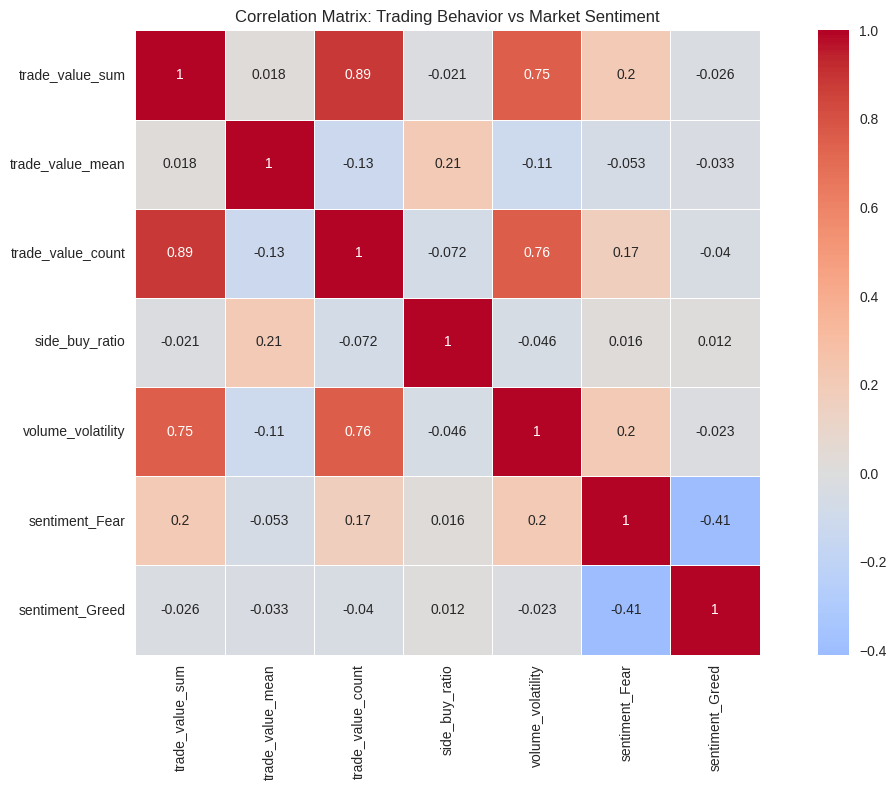

In [ ]:
# Advanced analysis for hidden patterns
def advanced_analysis(df):
    # 1. Volatility analysis
    df['volume_volatility'] = df['trade_value_sum'].rolling(window=7).std()
    df['next_day_volume'] = df['trade_value_sum'].shift(-1)

    # 2. Lag analysis - how sentiment affects next day trading
    df['next_day_volume'] = df['trade_value_sum'].shift(-1)
    df['next_day_buy_ratio'] = df['side_buy_ratio'].shift(-1)

    # 3. Correlation matrix
    correlation_cols = ['trade_value_sum', 'trade_value_mean', 'trade_value_count',
                    'side_buy_ratio', 'volume_volatility']


    # Create sentiment dummy variables
    df_encoded = pd.get_dummies(df, columns=['classification'], prefix='sentiment')

    # Calculate correlations
    corr_matrix = df_encoded[correlation_cols + ['sentiment_Fear', 'sentiment_Greed']].corr()

    # Visualize correlation matrix
    plt.figure(figsize=(12, 8))
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0,
                square=True, linewidths=0.5)
    plt.title('Correlation Matrix: Trading Behavior vs Market Sentiment')
    plt.tight_layout()
    plt.savefig('/content/outputs/correlation_matrix.png', dpi=300, bbox_inches='tight')
    plt.show()

    return df_encoded, corr_matrix

# Run advanced analysis
enhanced_data, correlation_matrix = advanced_analysis(merged_data)

# Save enhanced dataset
enhanced_data.to_csv('/content/csv_files/enhanced_analysis.csv', index=False)

In [ ]:
# Step 1: Identify sentiment columns
sentiment_cols = [
    'sentiment_Extreme Fear', 'sentiment_Extreme Greed',
    'sentiment_Fear', 'sentiment_Greed', 'sentiment_Neutral'
]

# Step 2: Get the sentiment label per row (column with max value)
enhanced_data['Classification'] = enhanced_data[sentiment_cols].idxmax(axis=1)

# Step 3: Clean up the column names
enhanced_data['Classification'] = enhanced_data['Classification'].str.replace('sentiment_', '')


=== MODEL PERFORMANCE ===
               precision    recall  f1-score   support

 Extreme Fear       0.00      0.00      0.00         1
Extreme Greed       0.42      0.56      0.48         9
         Fear       0.50      0.25      0.33         8
        Greed       0.53      0.73      0.62        11
      Neutral       0.00      0.00      0.00         3

     accuracy                           0.47        32
    macro avg       0.29      0.31      0.28        32
 weighted avg       0.43      0.47      0.43        32



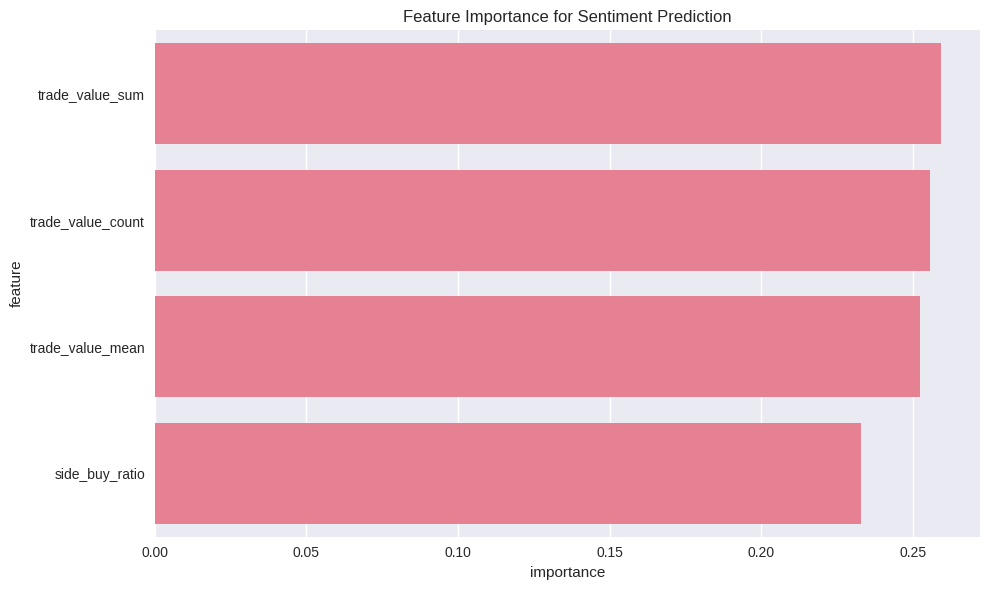

In [ ]:
# Build predictive models
def build_predictive_models(df):
    from sklearn.model_selection import train_test_split
    from sklearn.ensemble import RandomForestClassifier
    from sklearn.metrics import classification_report, confusion_matrix
    from sklearn.preprocessing import StandardScaler

    # Prepare features for prediction
    feature_cols = ['trade_value_sum', 'trade_value_mean', 'trade_value_count', 'side_buy_ratio']
    X = df[feature_cols].fillna(df[feature_cols].mean())
    y = df['Classification']

    # Split data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,
                                                        random_state=42,
                                                        stratify=y)

    # Scale features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Train Random Forest model
    rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
    rf_model.fit(X_train_scaled, y_train)

    # Make predictions
    y_pred = rf_model.predict(X_test_scaled)

    # Evaluate model
    print("=== MODEL PERFORMANCE ===")
    print(classification_report(y_test, y_pred))

    # Feature importance
    feature_importance = pd.DataFrame({
        'feature': feature_cols,
        'importance': rf_model.feature_importances_
    }).sort_values('importance', ascending=False)

    # Plot feature importance
    plt.figure(figsize=(10, 6))
    sns.barplot(data=feature_importance, x='importance', y='feature')
    plt.title('Feature Importance for Sentiment Prediction')
    plt.tight_layout()
    plt.savefig('/content/outputs/feature_importance.png', dpi=300, bbox_inches='tight')
    plt.show()

    return rf_model, feature_importance

# Build and evaluate model
model, feature_importance = build_predictive_models(enhanced_data)

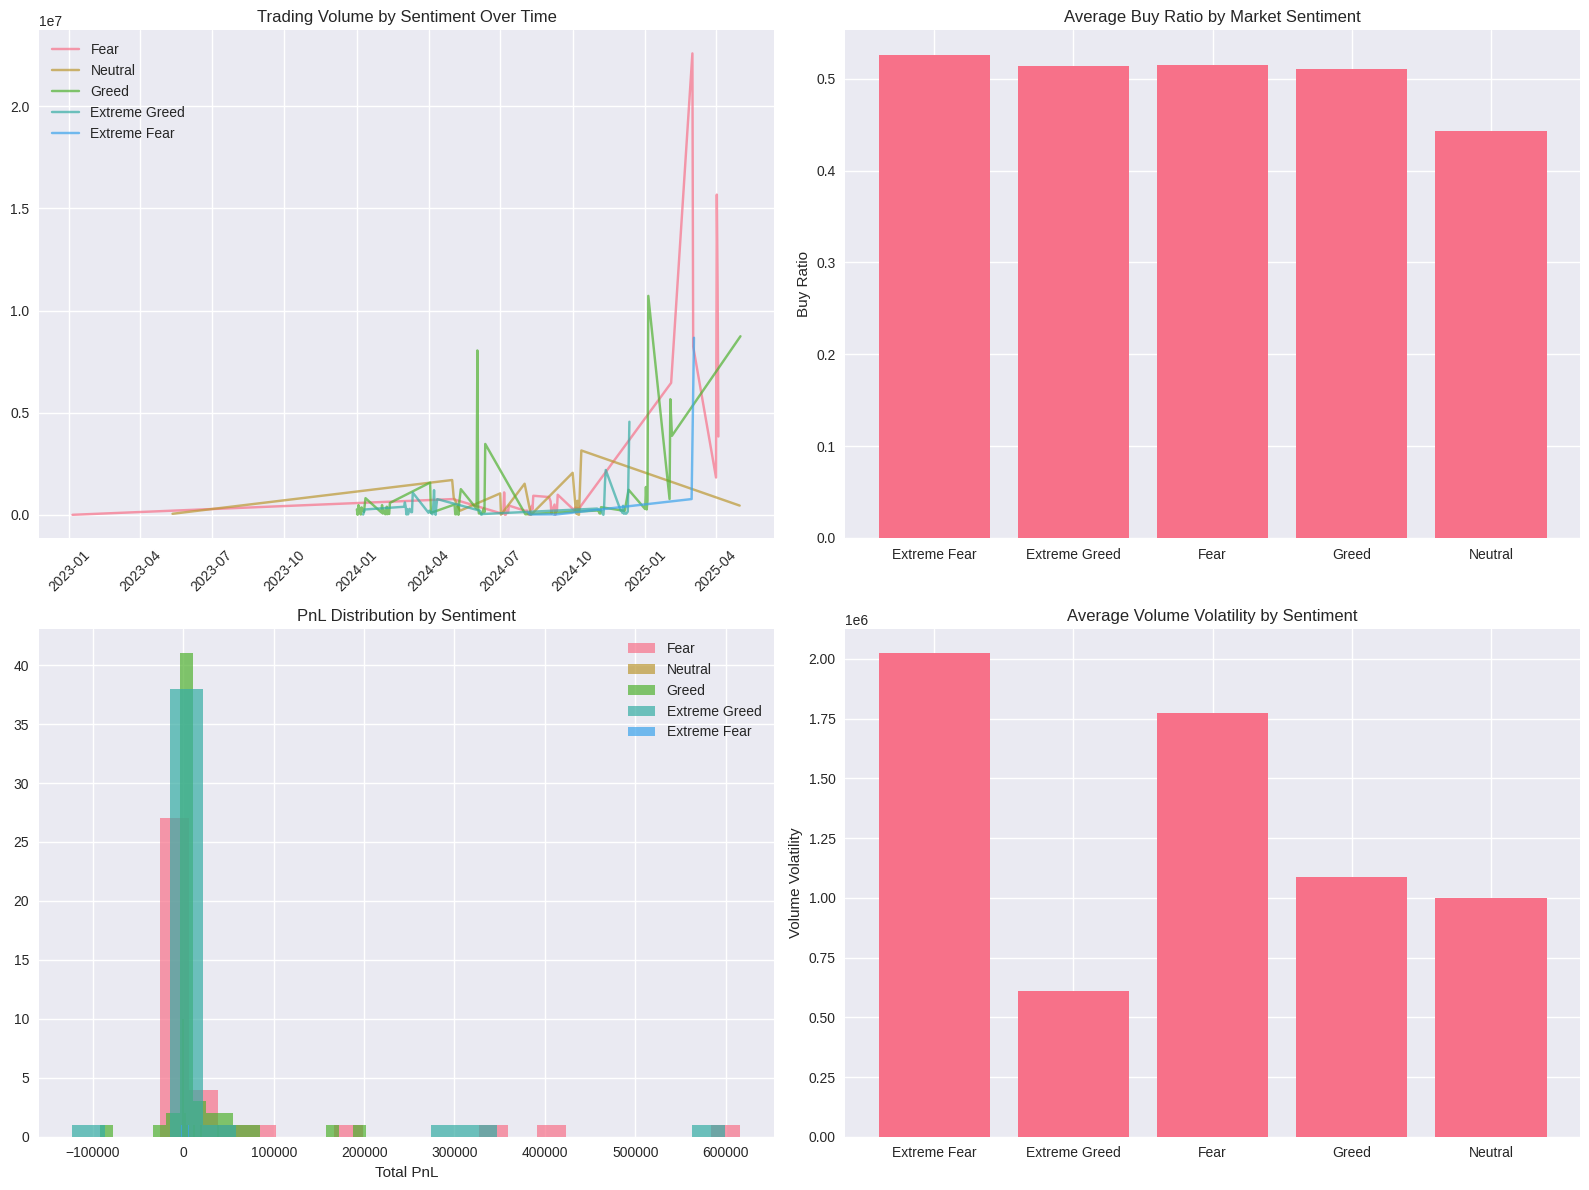

In [ ]:
# Develop trading strategy insights
def trading_strategy_insights(df):
    # 1. Optimal trading times based on sentiment
    # If timestamp is in seconds since epoch
    df['hour'] = pd.to_datetime(df['timestamp'], unit='s').dt.hour

    # Now the groupby will work
    enhanced_data['buy_ratio'] = enhanced_data['side_buy_ratio']
    enhanced_data['total_volume'] = enhanced_data['trade_value_sum']  # or size_usd_sum
    enhanced_data['total_pnl'] = enhanced_data['closed_pnl_sum']      # or avg/mean if needed
    # Ensure 'hour' is extracted
    enhanced_data['hour'] = pd.to_datetime(enhanced_data['timestamp'], unit='s').dt.hour


    # 2. Risk-adjusted returns by sentiment
    df['risk_adjusted_return'] = df['total_pnl'] / df['volume_volatility']

    # 3. Sentiment transition analysis
    df['sentiment_transition'] = df['Classification'].shift() + '_to_' + df['Classification']
    transition_performance = df.groupby('sentiment_transition').agg({
        'total_volume': 'mean',
        'total_pnl': 'mean',
        'buy_ratio': 'mean'
    }).reset_index()

    # Visualization
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))

    # Plot 1: Volume by sentiment over time
    for sentiment in df['Classification'].unique():
        sentiment_data = df[df['Classification'] == sentiment]
        axes[0,0].plot(sentiment_data['date'], sentiment_data['total_volume'],
                      label=sentiment, alpha=0.7)
    axes[0,0].set_title('Trading Volume by Sentiment Over Time')
    axes[0,0].legend()
    axes[0,0].tick_params(axis='x', rotation=45)

    # Plot 2: Buy ratio by sentiment
    buy_ratio_by_sentiment = df.groupby('Classification')['buy_ratio'].mean()
    axes[0,1].bar(buy_ratio_by_sentiment.index, buy_ratio_by_sentiment.values)
    axes[0,1].set_title('Average Buy Ratio by Market Sentiment')
    axes[0,1].set_ylabel('Buy Ratio')

    # Plot 3: PnL distribution by sentiment
    for sentiment in df['Classification'].unique():
        sentiment_data = df[df['Classification'] == sentiment]
        axes[1,0].hist(sentiment_data['total_pnl'].dropna(), alpha=0.7,
                      label=sentiment, bins=20)
    axes[1,0].set_title('PnL Distribution by Sentiment')
    axes[1,0].legend()
    axes[1,0].set_xlabel('Total PnL')

    # Plot 4: Volatility by sentiment
    volatility_by_sentiment = df.groupby('Classification')['volume_volatility'].mean()
    axes[1,1].bar(volatility_by_sentiment.index, volatility_by_sentiment.values)
    axes[1,1].set_title('Average Volume Volatility by Sentiment')
    axes[1,1].set_ylabel('Volume Volatility')

    plt.tight_layout()
    plt.savefig('/content/outputs/trading_strategy_insights.png', dpi=300, bbox_inches='tight')
    plt.show()

    return transition_performance

# Generate trading insights
transition_analysis = trading_strategy_insights(enhanced_data)

In [ ]:
def generate_summary_report(df, stats_results, correlation_matrix, feature_importance):
    print("="*60)
    print("COMPREHENSIVE ANALYSIS REPORT")
    print("="*60)

    print("\n1. DATASET OVERVIEW:")
    print(f"   - Analysis period: {df['date'].min()} to {df['date'].max()}")
    print(f"   - Total trading days: {len(df)}")
    print(f"   - Fear days: {len(df[df['Classification'] == 'Fear'])}")
    print(f"   - Greed days: {len(df[df['Classification'] == 'Greed'])}")

    print("\n2. KEY FINDINGS:")
    print("   - Trading volume during greed periods:",
          f"{stats_results.loc['trade_value_sum', 'greed_mean']:.2f}")
    print("   - Trading volume during fear periods:",
          f"{stats_results.loc['trade_value_sum', 'fear_mean']:.2f}")
    print("   - Buy ratio during greed periods:",
          f"{stats_results.loc['side_buy_ratio', 'greed_mean']:.2f}")
    print("   - Buy ratio during fear periods:",
          f"{stats_results.loc['side_buy_ratio', 'fear_mean']:.2f}")


    print("\n3. STATISTICAL SIGNIFICANCE:")
    for metric in stats_results.index:
        significance = "Significant" if stats_results.loc[metric, 'significant'] else "Not significant"
        print(f"   - {metric}: {significance} (p-value: {stats_results.loc[metric, 'p_value']:.4f})")

    print("\n4. CORRELATION INSIGHTS:")
    print("   - Strongest positive correlation with greed sentiment:")
    greed_corr = correlation_matrix['sentiment_Greed'].sort_values(ascending=False)
    print(f"     {greed_corr.index[1]}: {greed_corr.values[1]:.3f}")

    print("\n5. PREDICTIVE MODEL PERFORMANCE:")
    print("   - Most important features for sentiment prediction:")
    for i, row in feature_importance.head(3).iterrows():
        print(f"     {row['feature']}: {row['importance']:.3f}")

    print("\n6. TRADING STRATEGY RECOMMENDATIONS:")
    print("   - Monitor volume spikes during sentiment transitions")
    print("   - Higher buy ratios typically occur during greed periods")
    print("   - Consider contrarian strategies during extreme sentiment periods")

# Generate final report
generate_summary_report(enhanced_data, stats_results, correlation_matrix, feature_importance)

COMPREHENSIVE ANALYSIS REPORT

1. DATASET OVERVIEW:
   - Analysis period: 2023-01-05 00:00:00 to 2025-05-02 00:00:00
   - Total trading days: 158
   - Fear days: 37
   - Greed days: 56

2. KEY FINDINGS:
   - Trading volume during greed periods: 1018675.28
   - Trading volume during fear periods: 2153361.92
   - Buy ratio during greed periods: 0.51
   - Buy ratio during fear periods: 0.51

3. STATISTICAL SIGNIFICANCE:
   - trade_value_sum: Not significant (p-value: 0.1289)
   - trade_value_mean: Not significant (p-value: 0.7881)
   - trade_value_count: Not significant (p-value: 0.1161)
   - side_buy_ratio: Not significant (p-value: 0.9547)

4. CORRELATION INSIGHTS:
   - Strongest positive correlation with greed sentiment:
     side_buy_ratio: 0.012

5. PREDICTIVE MODEL PERFORMANCE:
   - Most important features for sentiment prediction:
     trade_value_sum: 0.259
     trade_value_count: 0.256
     trade_value_mean: 0.252

6. TRADING STRATEGY RECOMMENDATIONS:
   - Monitor volume spikes d

In [ ]:
# Export all results
def export_results():
    # Create outputs directory if it doesn't exist
    import os
    os.makedirs('/content/outputs', exist_ok=True)
    os.makedirs('/content/csv_files', exist_ok=True)

    # Export summary statistics
    stats_results.to_csv('/content/csv_files/statistical_analysis_results.csv')
    correlation_matrix.to_csv('/content/csv_files/correlation_matrix.csv')
    feature_importance.to_csv('/content/csv_files/feature_importance.csv')

    print("All results exported successfully!")
    print("\nFiles created:")
    print("- /content/csv_files/merged_trader_sentiment.csv")
    print("- /content/csv_files/enhanced_analysis.csv")
    print("- /content/csv_files/statistical_analysis_results.csv")
    print("- /content/csv_files/correlation_matrix.csv")
    print("- /content/csv_files/feature_importance.csv")
    print("- /content/outputs/trader_behavior_analysis.png")
    print("- /content/outputs/market_sentiment_analysis.png")
    print("- /content/outputs/correlation_matrix.png")
    print("- /content/outputs/feature_importance.png")
    print("- /content/outputs/trading_strategy_insights.png")

# Export all results
export_results()

All results exported successfully!

Files created:
- /content/csv_files/merged_trader_sentiment.csv
- /content/csv_files/enhanced_analysis.csv
- /content/csv_files/statistical_analysis_results.csv
- /content/csv_files/correlation_matrix.csv
- /content/csv_files/feature_importance.csv
- /content/outputs/trader_behavior_analysis.png
- /content/outputs/market_sentiment_analysis.png
- /content/outputs/correlation_matrix.png
- /content/outputs/feature_importance.png
- /content/outputs/trading_strategy_insights.png
